# 📘 `day3_4_parking_path_control.ipynb` Structure

In [ ]:
# 📘 Project File: day3_4_parking_path_control.ipynb

# ├── ✅ Step 1: Predict Strategy (MLP)
# │       └── Use trained model to classify:
# │           - Forward Perpendicular
# │           - Reverse Parallel
# │           - Cannot Park
#
# ├── ✅ Step 2: Generate p0, p1, p2
# │       └── Use `generate_control_points(...)`
# │           based on strategy, car, and spot dimensions
#
# ├── ✅ Step 3: Generate Bezier Path
# │       └── Create smooth curve using `generate_bezier_curve(...)`
# │           - Returns 50 (x, y) path points
#
# ├── ✅ Step 4: Animate Movement into Parking Spot
# │       ├── Add blue rectangle for car body
# │       ├── Add green rectangle for parking spot
# │       └── Animate car along bezier path (dot or box)
#
# ├── ✅ Step 5: (Optional) Export Animation
# │       ├── Save as `.gif` or `.mp4`
# │       └── Useful for reports or Streamlit app
#
# └── ✅ Step 6: Visualize `p1` Effect on Path
#         ├── Plot multiple Bezier curves with varying `p1`
#         └── Understand how midpoint affects parking shape


# ✅ Step 7: Auto‑Align to Parking Bay (Rotate → Translate)

# 	•	Auto-detect entry side:
# entry_side = 'bottom' if start_y < spot_origin[1] + spot_length/2 else 'top'
# 	•	Compute rear‑bumper target (center in x, inset from chosen edge in y):
# rear_target = compute_rear_target(spot_origin, spot_width, spot_length, car_length, inset=0.10, enter_from=entry_side)
# 	•	Lock the correct reference point (rear bumper, not car center):
# 	1.	Get current end pose → end_center, yaw_end
# 	2.	Convert to rear bumper → rear_now = rear_bumper_center(end_center, yaw_end, car_length)
# 	3.	Rotate first about rear_now to match desired yaw (90° for Forward Perpendicular, 0° for Reverse Parallel).
# 	4.	Translate next so rotated bumper lands exactly on rear_target.
# 	•	Visual debug: plot X (target) and + (after align). When they overlap, alignment is perfect.

# ✅ Step 8: Support Both Strategies (Forward & Reverse)

# 	•	Strategy switch:
# strategy = "Reverse Parallel" if use_reverse else "Forward Perpendicular"
# 	•	Path templates:
# 	•	Forward Perpendicular: multi‑segment (arc → short straight → arc) with heuristics from spot/car sizes (e.g., x_swing, approach_y).
# 	•	Reverse Parallel: pull-ahead → reverse arc into space → small forward arc to straighten.
# 	•	Final yaw policy:
# yaw_target = 90.0 if strategy == "Forward Perpendicular" else 0.0
# 	•	Unified alignment: both strategies pass through the same Step‑7 alignment (rear‑bumper target + rotate‑then‑translate).
# 	•	Auto entry side works for both (based on start_y vs. bay mid‑y), so you don’t need to manually flip top/bottom.

# 🚗 Day 3: Trajectory Planner
- generate_bezier_curve()
- Plot test

# 🎮 Day 4: Vehicle Controller
- calculate_vehicle_controls()
- Print instructions from Bezier path

	•	helpers → generate_path_for_strategy → build full_path → curve_points → auto‑align → animation → save ✅

Fits width: False  | Fits length: True
Saved GIF: parking_animation.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

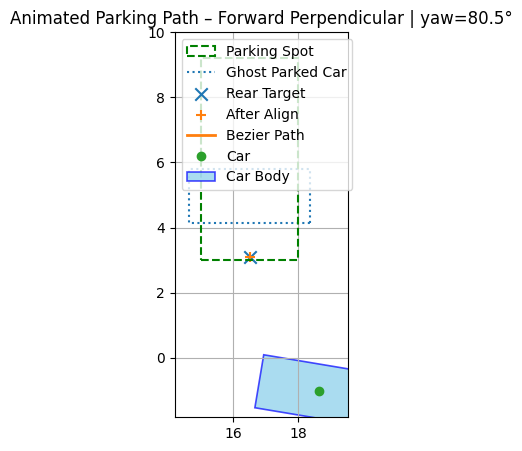

In [14]:
# ONE-CELL MULTI-SEGMENT PARK, AUTO-ALIGN, ROTATE, SAVE GIF/MP4

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.transforms import Affine2D
from IPython.display import HTML
from google.colab import files

# -------------------- Config --------------------
spot_length = 6.2
spot_width  = 3.0
car_length = spot_length * 0.6
car_width  = spot_width * 0.55
spot_origin = np.array([15.0, 3.0])
use_reverse = False
strategy = "Reverse Parallel" if use_reverse else "Forward Perpendicular"

# -------------------- Path helpers --------------------
def concat_paths(*paths):
    out = []
    for k, p in enumerate(paths):
        p = np.asarray(p)
        if k > 0 and len(out) and len(p):
            out.extend(p[1:])
        else:
            out.extend(p)
    return np.array(out)

def generate_bezier_curve(p0, p1, p2, n=40):
    t = np.linspace(0, 1, n).reshape(-1, 1)
    p0, p1, p2 = map(np.array, (p0, p1, p2))
    return (1 - t)**2 * p0 + 2*(1 - t)*t*p1 + t**2 * p2

def make_arc(start_xy, mid_offset, end_offset, n=40):
    sx, sy = start_xy
    p0 = (sx, sy)
    p1 = (sx + mid_offset[0], sy + mid_offset[1])
    p2 = (sx + end_offset[0], sy + end_offset[1])
    return generate_bezier_curve(p0, p1, p2, n)

def straight_segment(start_xy, length, heading_deg, n=15):
    sx, sy = start_xy
    rad = np.radians(heading_deg)
    ex, ey = sx + length*np.cos(rad), sy + length*np.sin(rad)
    return np.column_stack([np.linspace(sx, ex, n),
                            np.linspace(sy, ey, n)])

def heading_at(path, i):
    if i == 0:
        p_prev, p_curr = path[i], path[i+1]
    else:
        p_prev, p_curr = path[i-1], path[i]
    dx = p_curr[0] - p_prev[0]
    dy = p_curr[1] - p_prev[1]
    return np.degrees(np.arctan2(dy, dx))

# -------------------- Path generation --------------------
def generate_path_for_strategy(strategy, car_length, car_width, spot_length, spot_width, distance_to_spot,
                                nA=45, nS=12, nB=28):
    def clamp(v, lo, hi):
        return max(lo, min(hi, v))

    if strategy == "Forward Perpendicular":
        x_swing = clamp(0.4 * spot_width, 0.5, 1.4)
        approach_y = clamp(0.6 * distance_to_spot + 0.5 * spot_length,
                           1.2, distance_to_spot + spot_length - 0.4 * car_length)

        pathA = make_arc((0.0, 0.0), (+x_swing, 0.55 * approach_y),
                         (+0.25 * x_swing, approach_y), n=nA)
        pathS = straight_segment(tuple(pathA[-1]), length=0.3, heading_deg=85, n=nS)
        pathB = make_arc(tuple(pathS[-1]), (-0.45 * x_swing, 0.25 * spot_length),
                         (-0.18 * x_swing, 0.38 * spot_length), n=nB)
        return concat_paths(pathA, pathS, pathB)

    elif strategy == "Reverse Parallel":
        pull_ahead = clamp(0.8 * distance_to_spot, 0.6, 1.2)
        back_y = clamp(0.8 * spot_length, 1.8, 3.5)
        side_x = clamp(0.6 * spot_width + 0.4 * car_width, 0.9, 2.2)

        path0 = straight_segment((0.0, 0.0), length=pull_ahead, heading_deg=85, n=max(8, nS))
        pathA = make_arc(tuple(path0[-1]), (-0.6 * side_x, -0.55 * back_y),
                         (-1.0 * side_x, -1.0 * back_y), n=nA)
        pathB = make_arc(tuple(pathA[-1]), (+0.6 * side_x, +0.25 * back_y),
                         (+0.9 * side_x, +0.42 * back_y), n=nB)
        return concat_paths(path0, pathA, pathB)

    elif strategy == "Cannot Park":
        return None
    else:
        p0 = (0.0, 0.0)
        p2 = (0.0, max(1.5, distance_to_spot + 0.6 * spot_length))
        p1 = (0.8 * spot_width, 0.5 * (p0[1] + p2[1]))
        return generate_bezier_curve(p0, p1, p2, n=max(60, nA + nB))

# -------------------- Alignment helpers --------------------
def rear_bumper_center(center_xy, yaw_deg, car_length):
    rad = np.radians(yaw_deg)
    # forward unit vector = (cosθ, sinθ); rear bumper is half-length *behind* center
    return np.array(center_xy) - 0.5 * car_length * np.array([np.cos(rad), np.sin(rad)])

def rotate_path_about_point(points, center_xy, delta_deg):
    rad = np.radians(delta_deg)
    R = np.array([[np.cos(rad), -np.sin(rad)],
                  [np.sin(rad),  np.cos(rad)]])
    P = np.asarray(points) - center_xy
    P = P @ R.T
    P = P + center_xy
    return [tuple(p) for p in P]

def compute_rear_target(spot_origin, spot_width, spot_length, car_length,
                        inset=0.10, enter_from='bottom'):
    x = float(spot_origin[0]) + float(spot_width) / 2.0
    if enter_from == 'bottom':
        y = float(spot_origin[1]) + inset
    elif enter_from == 'top':
        y = float(spot_origin[1]) + float(spot_length) - inset
    else:
        raise ValueError("enter_from must be 'bottom' or 'top'")
    return np.array([x, y], dtype=float)

def car_corners(center_xy, yaw_deg, L, W):
    import numpy as np
    cx, cy = center_xy
    rad = np.radians(yaw_deg)
    R = np.array([[np.cos(rad), -np.sin(rad)],
                  [np.sin(rad),  np.cos(rad)]])
    # corners in car frame (center at 0,0)
    halfL, halfW = L/2, W/2
    local = np.array([
        [-halfW, -halfL],
        [ halfW, -halfL],
        [ halfW,  halfL],
        [-halfW,  halfL],
    ])
    world = local @ R.T + np.array([cx, cy])
    return world

# compute the *intended* parked center from rear_bumper target
theta = np.radians(90.0 if strategy == "Forward Perpendicular" else 0.0)
final_center = rear_target + 0.5 * car_length * np.array([np.cos(theta), np.sin(theta)])

C = car_corners(final_center, np.degrees(theta), car_length, car_width)

sx0, sy0 = float(spot_origin[0]), float(spot_origin[1])
sx1, sy1 = sx0 + float(spot_width), sy0 + float(spot_length)

fits_width  = (C[:,0].min() >= sx0) and (C[:,0].max() <= sx1)
fits_length = (C[:,1].min() >= sy0) and (C[:,1].max() <= sy1)
print("Fits width:", fits_width, " | Fits length:", fits_length)

# OPTIONAL: auto-shrink car width if too wide (keeps proportions nice)
clearance = 0.10  # meters desired clearance on each side
max_allowed_width = max(0.1, spot_width - 2*clearance)
if car_width > max_allowed_width:
    scale = max_allowed_width / car_width
    car_width  *= scale
    car_length *= scale * 0.98  # tiny taper to look natural
    print(f"Auto-shrunk car to width={car_width:.2f}, length={car_length:.2f}")

# -------------------- Build path --------------------
full_path = generate_path_for_strategy(strategy, car_length, car_width,
                                       spot_length, spot_width, distance_to_spot=1.0,
                                       nA=45, nS=12, nB=28)
if full_path is None:
    raise SystemExit
else:
    curve_points = [tuple(pt) for pt in full_path]

# Auto-detect entry direction
spot_mid_y = spot_origin[1] + spot_length / 2
start_y = curve_points[0][1]
entry_side = 'bottom' if start_y < spot_mid_y else 'top'
rear_target = compute_rear_target(spot_origin, spot_width, spot_length, car_length,
                                   inset=0.10, enter_from=entry_side)

# Rotate first, then translate
end_center = np.array(curve_points[-1])
yaw_end    = heading_at(curve_points, len(curve_points)-1)
rear_now   = rear_bumper_center(end_center, yaw_end, car_length)

yaw_target = 90.0 if strategy == "Forward Perpendicular" else 0.0
delta_yaw  = yaw_target - yaw_end
curve_points = rotate_path_about_point(curve_points, rear_now, delta_yaw)

end_center_rot = np.array(curve_points[-1])
yaw_end_rot    = heading_at(curve_points, len(curve_points)-1)
rear_now_rot   = rear_bumper_center(end_center_rot, yaw_end_rot, car_length)

delta = rear_target - rear_now_rot
curve_points = [(x + delta[0], y + delta[1]) for (x, y) in curve_points]
rear_now2 = rear_target.copy()

# -------------------- Figure --------------------
fig, ax = plt.subplots(figsize=(6,5))
ax.grid(True)

spot_rect = patches.Rectangle((spot_origin[0], spot_origin[1]),
                              spot_width, spot_length,
                              linewidth=1.5, edgecolor='green', facecolor='none',
                              linestyle='--', label='Parking Spot', zorder=5)
ax.add_patch(spot_rect)

# Optional: ghost parked car outline
ghost = car_corners(final_center, np.degrees(theta), car_length, car_width)
ax.plot([*ghost[:,0], ghost[0,0]], [*ghost[:,1], ghost[0,1]],
        linestyle=':', label='Ghost Parked Car')

ax.scatter(rear_target[0], rear_target[1], s=80, marker='x', label='Rear Target')
ax.scatter(rear_now2[0],   rear_now2[1],   s=60, marker='+', label='After Align')

curve_line, = ax.plot([], [], lw=2, label='Bezier Path')
car_dot,   = ax.plot([], [], 'o', label='Car')
car_rect = patches.Rectangle((0, 0), car_width, car_length,
                             linewidth=1.2, edgecolor='blue',
                             facecolor='skyblue', alpha=0.7, label='Car Body')
ax.add_patch(car_rect)

xs_path = [p[0] for p in curve_points]
ys_path = [p[1] for p in curve_points]
sx0, sy0 = float(spot_origin[0]), float(spot_origin[1])
sx1, sy1 = sx0 + float(spot_width), sy0 + float(spot_length)

pad = 0.8
ax.set_xlim(min(min(xs_path), sx0, sx1) - pad, max(max(xs_path), sx0, sx1) + pad)
ax.set_ylim(min(min(ys_path), sy0, sy1) - pad, max(max(ys_path), sy0, sy1) + pad)
ax.legend(loc='upper left')
ax.set_aspect('equal', adjustable='box')   # keep meters on x and y the same scale

# -------------------- Animation --------------------
def animate(i):
    x_vals = [pt[0] for pt in curve_points[:i+1]]
    y_vals = [pt[1] for pt in curve_points[:i+1]]

    curve_line.set_data(x_vals, y_vals)
    car_dot.set_data([x_vals[-1]], [y_vals[-1]])

    cx, cy = x_vals[-1], y_vals[-1]
    yaw = heading_at(curve_points, i)
    car_rect.set_xy((cx - car_width/2, cy - car_length/2))
    car_rect.set_transform(Affine2D().rotate_deg_around(cx, cy, yaw) + ax.transData)
    ax.set_title(f'Animated Parking Path – {strategy} | yaw={yaw:.1f}°')
    return curve_line, car_dot, car_rect

ani = FuncAnimation(fig, animate, frames=len(curve_points), interval=120, blit=False, repeat=False)
HTML(ani.to_jshtml())

# Save GIF
gif_path = "parking_animation.gif"
ani.save(gif_path, writer=PillowWriter(fps=12))
print("Saved GIF:", gif_path)
files.download(gif_path)

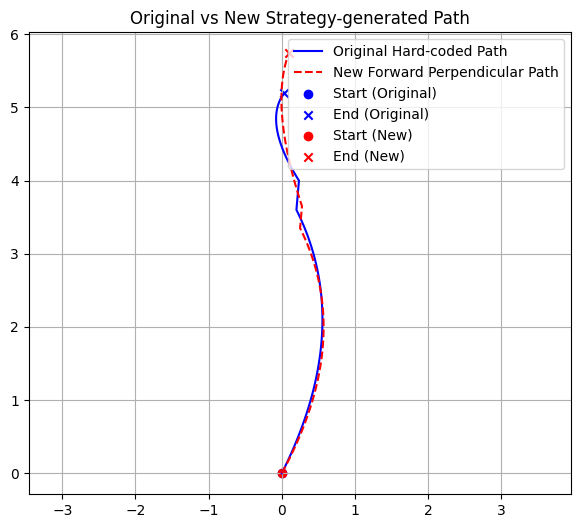

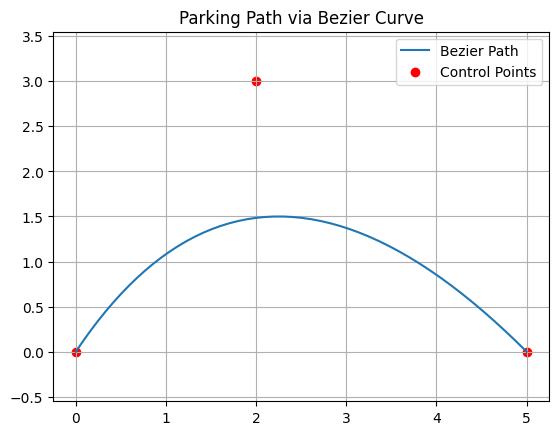

Step 1: Turn to 55.6°, Move 0.15m
Step 2: Turn to 54.2°, Move 0.14m
Step 3: Turn to 52.7°, Move 0.14m
Step 4: Turn to 51.1°, Move 0.13m
Step 5: Turn to 49.5°, Move 0.13m


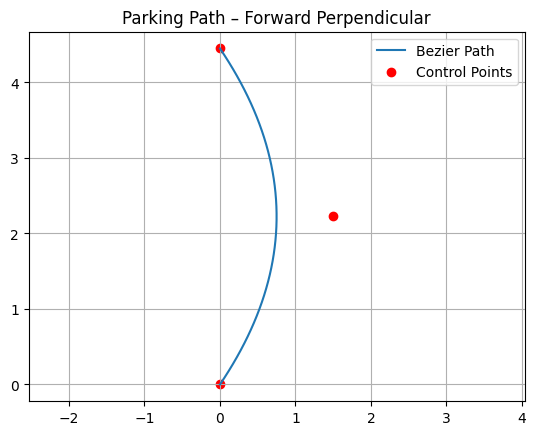

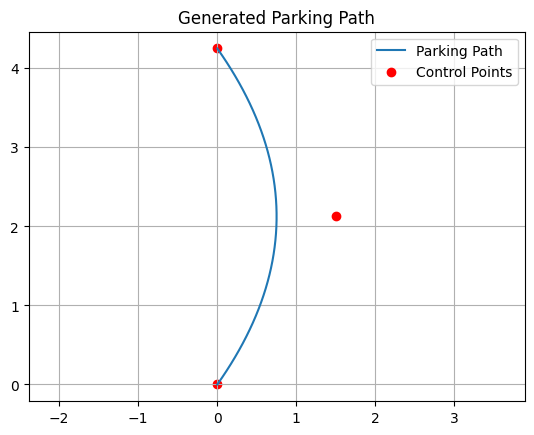

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)


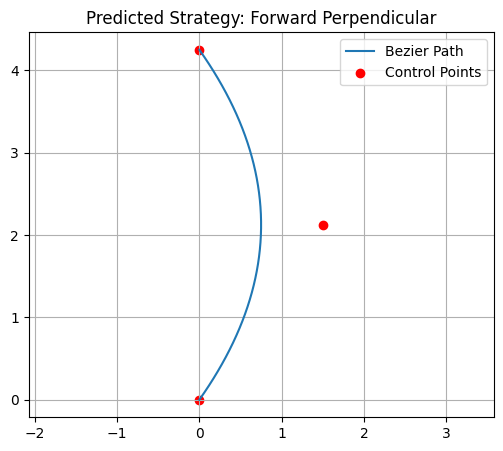

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)
✅ GIF saved as: parking_animation.gif


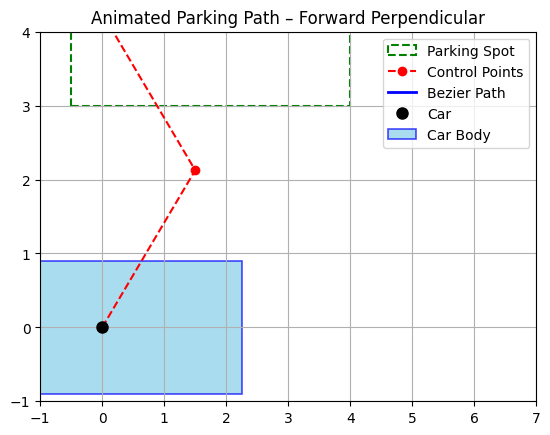